# A manual classification of dependency relations

Here, I will look into the distributive properties of a manual classification of dependency relations into two classes:

- __Content relations__: Dependencies that link a content word with another content word. 
- __Function relations__: Dependencies that link a word with a function word.

These are the relations that fit well within the specification of what I consider to be content and function dependencies. More fuzzy choices are further elaborated below.

### Content relations

acl, advcl, advmod, amod, appos, ccomp, compound, conj, csubj, csubjpass, dislocated, dobj, foreign, iobj, list, name, nmod, nsubj, nsubjpass, nummod, parataxis, remnant, root, vocative, xcomp

### Function relations

aux, auxpass, case, cc, cop, det, expl, mark, neg, punct

## Questionables

Some of these are more questionable than others.

### Content relations

__discourse__: Based on [the specification](http://universaldependencies.github.io/docs/u/dep/discourse.html) and each language's documentation, discourse seems to be used mainly for interjections, exclamations, emoticons, as well as a few language specific instances. While the [current distribution](/notebooks/Dependency%20distribution%20in%20Universal%20Dependency%20languages.ipynb) says otherwise, we would expect this to be fairly consistent across the languages. The fact that it isn't has probably more to do with treebank inconsistencies, as well as that some languages (Bulgarian) has more user generated text data. As such, we will classify it as a content relation. 

__reparandum__: Almost exclusively used in English. I expect this to rise in usage with speech treebanks becoming increasingly more common. This would be an important relation when comparing such treebanks.


### Function relations

__dep__: _unspecified dependency_ -- this is the goto dependency in cases where the parser cannot make a better guess about its relation. In theory, based on [its description](http://universaldependencies.github.io/docs/u/dep/dep.html), I would presume that the relation would only be available in the parser output. That said, looking at the [dependency distribution](/notebooks/Dependency%20distribution%20in%20Universal%20Dependency%20languages.ipynb), we can see that it is quite present in most notably Danish.  If it was the case that it was only in the parser output, its content/function classification wouldn't make any difference since we would use the gold standard as the main reference to compare the output against. In practice, though, that doesn't seem to be the case. Since we cannot assume any syntactic information on the relations, we will choose to ignore it (i.e. have it as a function relation).

__goeswith__: Almost exclusively used in English and Danish. We cannot make any assumptions about its syntatic information, and is of little significance (in my opinion) when evaluating the quality of the parser. 

__mwe__: multi-word expressions are idiomatically coded expressions, often between function words with our without a content word. Since the word order often is quite strict, and [some](http://universaldependencies.github.io/docs/en/dep/mwe.html) [languages](http://universaldependencies.github.io/docs/fi/dep/mwe.html) even lists all(?) of them, we expect them to be fairly easy to parse and give big benefits for languages with many such relations.


### Found quirks

__compound__: German tokenizes e.g. _T-shirt_ into _T_, _\-\-_, and _shirt_ with a compound relation between _shirt_ and _T_, while Swedish keeps it as one token. This causes German to have quite a few more compound relations than similar languages. (1114 in German training data, 6 in Swedish).

# Distribution of function relations

In [9]:
function_relations = ['aux', 'auxpass', 'case', 'cc', 'cop', 'det', 'expl', 'mark', 'neg', 'punct', 'dep', 'goeswith', 'mwe']

In [4]:
# Increase figure size
%matplotlib inline
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)

treebank_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1"

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys
import fileinput
import pandas as pd
import seaborn as sns

from os import listdir
from os.path import join
from collections import defaultdict
from scipy.stats import entropy
from matplotlib import pylab

# Languages ordered according to their sTTR score (see other notebook for how).
sttr_order = ['UD_Finnish',
              'UD_Basque',
              'UD_Finnish-FTB',
              'UD_Hebrew',
              'UD_Czech',
              'UD_Indonesian',
              'UD_German',
              'UD_Hungarian',
              'UD_Greek',
              'UD_Croatian',
              'UD_Danish',
              'UD_Bulgarian',
              'UD_French',
              'UD_Spanish',
              'UD_Irish',
              'UD_Swedish',
              'UD_Italian',
              'UD_Persian',
              'UD_English']


# Extract treebank paths. Lists are necessary since Czech has multiple files.
train_files = {'UD_Basque': ['eu-ud-train.conllu'], 
              'UD_Croatian': ['hr-ud-train.conllu'], 
              'UD_Danish': ['da-ud-train.conllu'], 
              'UD_Finnish': ['fi-ud-train.conllu'], 
              'UD_French': ['fr-ud-train.conllu'], 
              'UD_Greek': ['el-ud-train.conllu'], 
              'UD_Hungarian': ['hu-ud-train.conllu'], 
              'UD_Irish': ['ga-ud-train.conllu'], 
              'UD_Persian': ['fa-ud-train.conllu'], 
              'UD_Swedish': ['sv-ud-train.conllu'], 
              'UD_Bulgarian': ['bg-ud-train.conllu'], 
              'UD_Czech': ['cs-ud-train-c.conllu',
                           'cs-ud-train-m.conllu',
                           'cs-ud-train-v.conllu',
                           'cs-ud-train-l.conllu'], 
              'UD_English': ['en-ud-train.conllu'], 
              'UD_Finnish-FTB': ['fi_ftb-ud-train.conllu'], 
              'UD_German': ['de-ud-train.conllu'], 
              'UD_Hebrew': ['he-ud-train.conllu'], 
              'UD_Indonesian': ['id-ud-train.conllu'], 
              'UD_Italian': ['it-ud-train.conllu'], 
              'UD_Spanish': ['es-ud-train.conllu']}

# UD_Language: [filepaths]
treebanks = {f: [join(treebank_path, f, train_file) for train_file in train_files[f]]
             for f in listdir(treebank_path) 
             if f.startswith("UD_")}  # remove hidden files

class Tree:
    def __init__(self, tree):
        self.raw = tree
        # Counts the dependency relations
        self.deprel_count = self._raw_to_deprel_count(tree)
    
    def _raw_to_deprel_count(self, tree):
        deprels = defaultdict(int)
        for line in tree:
            w_id = line.split()[0]
            # removing finegrained relations
            deprel = line.split()[7].split(":")[0]
            if "-" in w_id:
                continue
            
            deprels[deprel] += 1
            
        return deprels
    
def to_trees(f):
    tree = []
    for line in f:
        line = line.strip()
        if line.startswith("#"):
            continue
            
        if len(line) == 0:  # end of tree
            yield Tree(tree)
            tree.clear()
            continue

        tree.append(line)

def parse_conllu(conllu_path):
    # fileinput.input takes a list of files and treats them as one
    with fileinput.input(conllu_path) as f:  
        for tree in to_trees(f):
            yield tree
            
def sum_deprels(trees):
    deprels = defaultdict(int)
    for tree in trees:
        for rel, freq in tree.deprel_count.items():
            deprels[rel] += freq
    return deprels

df_dict = {}
for language, treebank in treebanks.items():
    deprels = sum_deprels(parse_conllu(treebank))
    df_dict[language] = deprels

deprel_per_lang = pd.DataFrame.from_dict(df_dict).transpose()

# Language ratio of function relations

The ratio of function dependencies for each language. They seem to be especially common in roman languages. Luckily, we find Finnish at the bottom just as expected.

In [81]:
function_dist = deprel_per_lang.div(deprel_per_lang.sum(axis=1), axis=0).fillna(0)[function_relations]
language_function_ratio = function_dist.sum(axis=1).sort_values(ascending=False)
language_function_ratio

UD_Italian        0.521308
UD_French         0.503894
UD_Spanish        0.497181
UD_Danish         0.495561
UD_German         0.483696
UD_Hebrew         0.480870
UD_Greek          0.462159
UD_Bulgarian      0.435105
UD_Swedish        0.427339
UD_English        0.424183
UD_Irish          0.420454
UD_Persian        0.382202
UD_Croatian       0.375274
UD_Hungarian      0.373001
UD_Basque         0.372706
UD_Czech          0.357248
UD_Indonesian     0.356543
UD_Finnish-FTB    0.326208
UD_Finnish        0.289176
dtype: float64

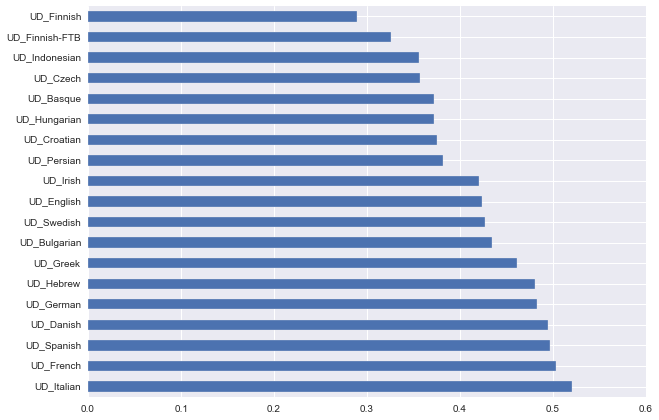

In [49]:
language_function_ratio.plot(kind='barh')

## Heatmap of function relations

The languages are sorted according to the sTTR previously calculated. We can see that especially _det_, and _case_ are much more commonly used among the more isolated languages. It's a bit more difficult to say anything about the others.

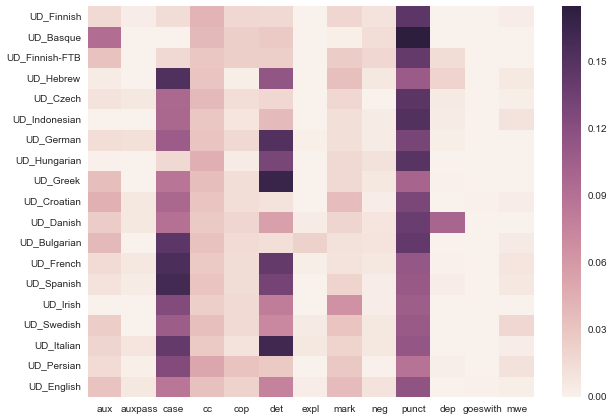

In [80]:
sns.heatmap(function_dist.ix[sttr_order])

## Correlation between ratio of function relations and the standard type-token ratio

If the function distribution and the sTTR have a strong correlation, I would say we have a pretty strong motivation of our choice of relations.

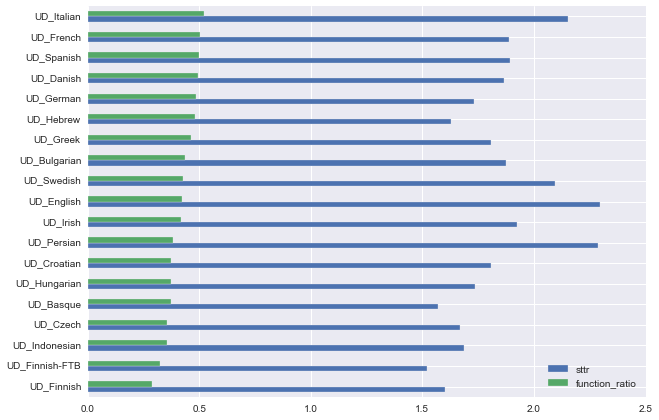

In [67]:
sttr = pd.DataFrame.from_csv('../data/standard_ttr.1.1.csv')['mean']
sttr_function_ratio = pd.concat([sttr, language_function_ratio], axis=1)
sttr_function_ratio.columns = ['sttr', 'function_ratio']
sttr_function_ratio.sort_values('function_ratio').plot(kind='barh')

In [84]:
sttr_function_ratio.sort_values('sttr').corr('pearson')

,sttr,function_ratio
sttr,1.000000,0.395544
function_ratio,0.395544,1.000000


Maybe we need to look a bit closer at some of our choices to raise the correlation coefficient. 